# KCNI Summer School 2022 - PyTorch WBM Project

In [13]:
from google.colab import drive
drive.mount("/content/drive")
# @title Mount Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Approximate run duration: XX

## Setup

Importage

In [14]:
# Standard base / scientific python stuff
import os,sys,glob,time,numpy as np,pandas as pd

# Vizualization stuff
from matplotlib import  pyplot as plt
import seaborn as sns

# Neuroimaging stuff
import nibabel as nib

# Google colab stuff
from google.colab import drive

# PyTorch and additional numpy stuff for the model
import torch
import torch.optim as optim
from torch.nn.parameter import Parameter
from numpy import diag,abs,array,eye,sqrt,zeros_like
from numpy.linalg import eigh,inv

Mount drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


## PyTorch Whole-Brain Model Fitting Code

In [15]:
# -*- coding: utf-8 -*-
"""
Authors: Zheng Wang, John Griffiths, Hussain Ather
WongWangDeco Model fitting
module for forward model (wwd) to simulate a batch of BOLD signals
input: noises, updated model parameters and current state (6)
outputs: updated current state and a batch of BOLD signals
"""

"""
WWD_Model_tf.py 
This file performs the modelling and graph-building for the Wong-Wang neuronal mass model
in determining network activity. 
This large-scale dynamic mean field model (DMF) approximates the average ensemble 
behavior, instead of considering the detailed interactions between individual 
neurons. This allow us varying the parameters and, furthermore, to greatly 
simplify the system of stochastic differential equations by expressing it 
in terms of the first and second-order statistical moments, means and 
covariances, of network activity. In the following we present the 
details of the model and its simplified versions.  
"""

def h_tf(a, b, d, z):
    """
    Neuronal input-output functions of excitatory pools and inhibitory pools.  
            
    Take the variables a, x, and b and convert them to a linear equation (a*x - b) while adding a small 
    amount of noise 0.00001 while dividing that term to an exponential of the linear equation multiplied by the 
    d constant for the appropriate dimensions.  
    """
    num = 0.00001 + torch.abs(a * z - b)
    den = 0.00001 * d + torch.abs(1.0000 - torch.exp(-d * (a * z - b)))
    return torch.divide(num, den)


class RNNWWD(torch.nn.Module):
    """
    A module for forward model (WWD) to simulate a batch of BOLD signals
    
    Attibutes
    ---------
    state_size : int
        the number of states in the WWD model
    input_size : int
        the number of states with noise as input
    tr : float
        tr of fMRI image
    step_size: float
        Integration step for forward model
    hidden_size: int
        the number of step_size in a tr 
    batch_size: int
        the number of BOLD signals to simulate
    node_size: int
        the number of ROIs
    sc: float node_size x node_size array   
        structural connectivity
    fit_gains: bool
        flag for fitting gains 1: fit 0: not fit
    g, g_EE, gIE, gEI: tensor with gradient on
        model parameters to be fit
    w_bb: tensor with node_size x node_size (grad on depends on fit_gains)
        connection gains
    std_in std_out: tensor with gradient on
        std for state noise and output noise
    g_m g_v sup_ca sup_cb sup_cc: tensor with gradient on
        hyper parameters for prior distribution of g gIE and gEI
    Methods
    -------
    forward(input, noise_out, hx)
        forward model (WWD) for generating a number of BOLD signals with current model parameters
    """
    def __init__(self, input_size: int, node_size: int,
                 batch_size: int, step_size: float, tr: float, sc: float, fit_gains: bool, \
                 g_mean_ini=100, g_std_ini = 2.5, gEE_mean_ini=2.5, gEE_std_ini = .5) -> None:
        """
        Parameters
        ----------
        state_size : int
        the number of states in the WWD model
        input_size : int
            the number of states with noise as input
        tr : float
            tr of fMRI image
        step_size: float
            Integration step for forward model
        hidden_size: int
            the number of step_size in a tr 
        batch_size: int
            the number of BOLD signals to simulate
        node_size: int
            the number of ROIs
        sc: float node_size x node_size array   
            structural connectivity
        fit_gains: bool
            flag for fitting gains 1: fit 0: not fit
        g_mean_ini: float, optional
            prior mean of g (default 100)
        g_std_ini: float, optional
            prior std of g (default 2.5)
        gEE_mean_ini: float, optional
            prior mean of gEE (default 2.5)
        gEE_std_ini: float, optional
            prior std of gEE (default 0.5)
        """
        super(RNNWWD, self).__init__()
        self.state_size = 6 # 6 states WWD model
        self.input_size = input_size # 1 or 2 
        self.tr = tr # tr fMRI image
        self.step_size = torch.tensor(step_size , dtype=torch.float32) # integration step 0.05
        self.hidden_size = int(tr/step_size)
        self.batch_size = batch_size # size of the batch used at each step
        self.node_size = node_size # num of ROI      
        self.sc = sc # matrix node_size x node_size structure connectivity
        self.fit_gains = fit_gains # flag for fitting gains
  
        # model parameters (variables: need to calculate gradient)
        # fix initials
        self.g_EI = Parameter(torch.tensor(.1, dtype=torch.float32)) # local gain E to I
        self.g_IE = Parameter(torch.tensor(.1, dtype=torch.float32)) # local gain I to E  # in the model we fix gII = 1.0 (local gain I to I)
        self.std_in = Parameter(torch.tensor(0.05, dtype=torch.float32)) # noise for dynamics
        self.std_out = Parameter(torch.tensor(0.02, dtype=torch.float32)) # noise for output
        # define initals for g and gEE
        if g_std_ini == 0:
            self.g = Parameter(torch.tensor(g_mean_ini, dtype=torch.float32)) # global gain
        else:
            g_hi = g_mean_ini+3*g_std_ini
            g_lo = g_mean_ini-3*g_std_ini
            if g_lo < 0:
                g_lo = 0
            self.g = Parameter(torch.tensor(np.random.uniform(g_lo,g_hi,1), dtype=torch.float32)) # global gain
        if gEE_std_ini == 0:
            self.g_EE = Parameter(torch.tensor(gEE_mean_ini, dtype=torch.float32)) # global gain
        else:
            gEE_hi = gEE_mean_ini+3*gEE_std_ini
            gEE_lo = gEE_mean_ini-3*gEE_std_ini
            if gEE_lo < 0:
                gEE_lo = 0 
            self.g_EE = Parameter(torch.tensor(np.random.uniform(gEE_lo,gEE_hi,1), dtype=torch.float32)) # local gain E to E
        # hyper parameters (variables: need to calculate gradient) to fit density 
        # of gEI and gIE (the shape from the bifurcation analysis on an isloated node)
        self.sup_ca = Parameter(torch.tensor(0.5, dtype=torch.float32)) 
        self.sup_cb = Parameter(torch.tensor(20, dtype=torch.float32))
        self.sup_cc = Parameter(torch.tensor(10, dtype=torch.float32))
        # gEE
        self.g_m = Parameter(torch.tensor(g_mean_ini, dtype=torch.float32))
        self.g_v = Parameter(torch.tensor(1/g_std_ini, dtype=torch.float32))
        self.g_EE_m = Parameter(torch.tensor(gEE_mean_ini, dtype=torch.float32))
        self.g_EE_v = Parameter(torch.tensor(1/gEE_std_ini, dtype=torch.float32))
        if self.fit_gains == True:
            self.w_bb = Parameter(torch.tensor(np.zeros((node_size,node_size)) + 0.05, dtype=torch.float32)) # connenction gain to modify empirical sc
        else:
            self.w_bb = torch.tensor(np.zeros((node_size,node_size)), dtype=torch.float32)
        # Parameters for the ODEs ( constants for pytorch: no need for gradient calculation)
        # Excitatory population
        self.W_E = torch.tensor(1., dtype=torch.float32) # scale of the external input
        self.tau_E = torch.tensor(100., dtype=torch.float32) # decay time
        self.gamma_E = torch.tensor(0.641/1000.,dtype=torch.float32) # other dynamic parameter (?)
        # Inhibitory population
        self.W_I = torch.tensor(0.7, dtype= torch.float32) # scale of the external input
        self.tau_I = torch.tensor(10., dtype=torch.float32) # decay time
        self.gamma_I = torch.tensor(1./1000., dtype=torch.float32) # other dynamic parameter (?)
        # External input
        self.I_0 = torch.tensor(0.32, dtype=torch.float32) # external input
        #self.sigma =  torch.tensor(0.02, dtype=torch.float32) # noise std
        # parameters for the nonlinear function of firing rate 
        self.aE = torch.tensor(310, dtype=torch.float32) 
        self.bE = torch.tensor(125, dtype=torch.float32)
        self.dE = torch.tensor(0.16, dtype=torch.float32)
        self.aI = torch.tensor(615, dtype=torch.float32)
        self.bI = torch.tensor(177, dtype=torch.float32) 
        self.dI = torch.tensor(0.087, dtype=torch.float32) 
        # parameters for Balloon dynamics (BOLD signal)
        self.alpha = torch.tensor(0.32, dtype=torch.float32) # stiffness component
        self.rho = torch.tensor(0.34, dtype=torch.float32) # resting oxygen extraction fraction
        self.k1 = torch.tensor(2.38, dtype=torch.float32)
        self.k2 = torch.tensor(2.0, dtype=torch.float32)
        self.k3 = torch.tensor(0.48, dtype=torch.float32)
        self.V = torch.tensor(.02, dtype=torch.float32) # resting blood volume fraction
        self.E0 = torch.tensor(0.34, dtype=torch.float32) # the capillary bed
        self.tau_s = torch.tensor(0.65, dtype=torch.float32) # time constant of decay
        self.tau_f = torch.tensor(0.41, dtype=torch.float32) # time constant of autoregulation
        self.tau_0 = torch.tensor(0.98, dtype=torch.float32) # mean transit time through balloon at rest
    
    """def check_input(self, input: Tensor) -> None:
        expected_input_dim = 2 
        if input.dim() != expected_input_dim:
            raise RuntimeError(
                'input must have {} dimensions, got {}'.format(
                    expected_input_dim, input.dim()))
        if self.input_size != input.size(-1):
            raise RuntimeError(
                'input.size(-1) must be equal to input_size. Expected {}, got {}'.format(
                    self.input_size, input.size(-1)))
            
        if self.batch_size != input.size(0):
            raise RuntimeError(
                'input.size(0) must be equal to batch_size. Expected {}, got {}'.format(
                    self.batch_size, input.size(0)))"""
    
    
    def forward(self, input, noise_out, hx):
        """
        Forward step in simulating the BOLD signal. 
        Parameters
        ----------
        input: tensor with node_size x hidden_size x batch_size x input_size
            noise for states
        noise_out: tensor with node_size x batch_size
            noise for BOLD
        hx: tensor with node_size x state_size
            states of WWD model
        Outputs
        -------
        next_state: dictionary with keys:
        'current_state''bold_batch''E_batch''I_batch''x_batch''f_batch''v_batch''q_batch'
            record new states and BOLD
        """
        next_state = {}
        # hx is current state (6) 0: E 1:I (neural activitiveties) 2:x 3:f 4:v 5:f (BOLD)
            
        E = hx[:,0:1]
        I = hx[:,1:2]
        x = hx[:,2:3]
        f = hx[:,3:4]
        v = hx[:,4:5]
        q = hx[:,5:6]
        dt = self.step_size
        con_1 = torch.ones_like(dt)
        
        # Update the Laplacian based on the updated connection gains w_bb. 
        w = (1.0+torch.tanh(self.w_bb))*torch.tensor(self.sc, dtype=torch.float32)#(con_1 + torch.tanh(self.w_bb))*torch.tensor(self.sc, dtype=torch.float32)
        w_n = 0.5*(w + torch.transpose(w, 0, 1))/torch.linalg.norm(0.5*(w + torch.transpose(w, 0, 1)))
        self.sc_m = w_n
        l_s = -torch.diag(torch.sum(w_n, axis =1)) + w_n 
        
        # placeholder for the updated corrent state
        current_state = torch.zeros_like(hx)
        
        # Generate the ReLU module for model parameters gEE gEI and gIE
        m_gEE = torch.nn.ReLU()
        m_gIE = torch.nn.ReLU()
        m_gEI = torch.nn.ReLU()
        m_std_in = torch.nn.ReLU()
        m_std_out = torch.nn.ReLU()
        
        
        # placeholders for output BOLD, history of E I x f v and q
        bold_batch = []
        E_batch = []
        I_batch = []
        x_batch = []
        f_batch = []
        v_batch = []
        q_batch = []
    
        # Use the forward model to get BOLD signal at ith element in the batch. 
        for i_batch in range(self.batch_size):
            # Get the noise for BOLD output. 
            noiseBold = noise_out[:,i_batch:i_batch+1]
            # Generate the ReLU module for model parameter m_cBOLD (used for calculating the magnitude of the BOLD signal).
            # The rectified linear activation function or ReLU for short is a piecewise linear function that 
            # will output the input directly if it is positive, otherwise, it will output zero.
            m_cBOLD = torch.nn.ReLU()
            
            # Since tr is about second we need to use a small step size like 0.05 to integrate the model states. 
            for i_hidden in range(self.hidden_size):
                
                # Generate ReLU module for input recurrent IE and II. 
                m_IE = torch.nn.ReLU()
                m_II = torch.nn.ReLU()
                
                # Input noise for E and I. 
                noiseE = input[:,i_hidden, i_batch,0:1]
                noiseI = input[:,i_hidden, i_batch,1:2]
                
                # Calculate the input recurrents. 
                IE = torch.tanh(m_IE(self.W_E*self.I_0 + (0.001*con_1 + m_gEE(self.g_EE))*E \
                     + self.g*torch.matmul(l_s, E) - (0.001*con_1 + m_gIE(self.g_IE))*I)) # input currents for E
                II = torch.tanh(m_II(self.W_I*self.I_0 + (0.001*con_1 + m_gIE(self.g_EI))*E -I)) # input currents for I 
                
                # Calculate the firing rates. 
                rE = h_tf(self.aE, self.bE, self.dE, IE) # firing rate for E
                rI = h_tf(self.aI, self.bI, self.dI, II) # firing rate for I 
                # Update the states by step-size 0.05. 
                ddE = E + dt*(-E*torch.reciprocal(self.tau_E) +self.gamma_E*(1.-E)*rE) \
                      + torch.sqrt(dt)*noiseE*(0.02*con_1 + m_std_in(self.std_in))### equlibrim point at E=(tau_E*gamma_E*rE)/(1+tau_E*gamma_E*rE)
                ddI = I + dt*(-I*torch.reciprocal(self.tau_I) +self.gamma_I*rI) \
                      + torch.sqrt(dt)*noiseI * (0.02*con_1 + m_std_in(self.std_in))
                
                dx = x + dt*(E  - torch.reciprocal(self.tau_s) * x - torch.reciprocal(self.tau_f)* (f - con_1))
                df = f + dt*x
                dv = v + dt*(f - torch.pow(v, torch.reciprocal(self.alpha))) * torch.reciprocal(self.tau_0)
                dq = q + dt*(f * (con_1 - torch.pow(con_1 - self.rho, torch.reciprocal(f)))*torch.reciprocal(self.rho) \
                            - q * torch.pow(v, torch.reciprocal(self.alpha)) *torch.reciprocal(v)) \
                              * torch.reciprocal(self.tau_0)
                
                # Calculate the saturation for model states (for stability and gradient calculation). 
                E = torch.tanh(0.00001+torch.nn.functional.relu(ddE))
                I = torch.tanh(0.00001+ torch.nn.functional.relu(ddI))
                x = torch.tanh(dx)
                f = (con_1 + torch.tanh(df - con_1))
                v = (con_1 + torch.tanh(dv - con_1))
                q = (con_1 + torch.tanh(dq - con_1))
                
                # Put each time step E and I into placeholders (need them to calculate Entropy of E and I 
                # in the loss (maximize the entropy)). 
                E_batch.append(E)
                I_batch.append(I)
                
            # Put x f v q from each tr to the placeholders for checking them visually.
            x_batch.append(x)
            f_batch.append(f)
            v_batch.append(v)
            q_batch.append(q)
            # Put the BOLD signal each tr to the placeholder being used in the cost calculation.
            bold_batch.append(1*(0.001*con_1 + m_std_out(self.std_out))*noiseBold + \
                               100.0*self.V*torch.reciprocal(self.E0)*(self.k1 * (con_1 - q) \
                                + self.k2 * (con_1 - q *torch.reciprocal(v)) + self.k3 * (con_1 - v)) )
        
        # Update the current state. 
        current_state = torch.cat([E, I, x, f, v, q], axis = 1)
        next_state['current_state'] = current_state
        next_state['bold_batch'] = torch.cat(bold_batch, axis=1)
        next_state['E_batch'] = torch.cat(E_batch, axis=1)
        next_state['I_batch'] = torch.cat(I_batch, axis=1)
        next_state['x_batch'] = torch.cat(x_batch, axis=1)
        next_state['f_batch'] = torch.cat(f_batch, axis=1)
        next_state['v_batch'] = torch.cat(v_batch, axis=1)
        next_state['q_batch'] = torch.cat(q_batch, axis=1)
        return next_state

def cost_r(logits_series_tf, labels_series_tf):
    """
    Calculate the Pearson Correlation between the simFC and empFC. 
    From there, the probability and negative log-likelihood.
    Parameters
    ----------
    logits_series_tf: tensor with node_size X datapoint
        simulated BOLD
    labels_series_tf: tensor with node_size X datapoint
        empirical BOLD
    """
    # get node_size(batch_size) and batch_size()
    node_size = logits_series_tf.shape[0]
    truncated_backprop_length = logits_series_tf.shape[1]
    
    # remove mean across time
    labels_series_tf_n = labels_series_tf - torch.reshape(torch.mean(labels_series_tf, 1), [node_size, 1])# - torch.matmul(
        
    logits_series_tf_n = logits_series_tf - torch.reshape(torch.mean(logits_series_tf, 1), [node_size, 1])#- torch.matmul(
        
    # correlation
    cov_sim = torch.matmul(logits_series_tf_n, torch.transpose(logits_series_tf_n, 0, 1))
    cov_def = torch.matmul(labels_series_tf_n, torch.transpose(labels_series_tf_n, 0, 1))
    
    # fc for sim and empirical BOLDs
    FC_sim_T = torch.matmul(torch.matmul(torch.diag(torch.reciprocal(torch.sqrt(\
                                          torch.diag(cov_sim)))), cov_sim),
                         torch.diag(torch.reciprocal(torch.sqrt(torch.diag(cov_sim)))))
    FC_T = torch.matmul(torch.matmul(torch.diag(torch.reciprocal(torch.sqrt(\
                            torch.diag(cov_def)))), cov_def),
                     torch.diag(torch.reciprocal(torch.sqrt(torch.diag(cov_def)))))
    
    # mask for lower triangle without diagonal
    ones_tri = torch.tril(torch.ones_like(FC_T), -1)
    zeros = torch.zeros_like(FC_T)  # create a tensor all ones
    mask = torch.greater(ones_tri, zeros)  # boolean tensor, mask[i] = True iff x[i] > 1
    # mask out fc to vector with elements of the lower triangle
    FC_tri_v = torch.masked_select(FC_T, mask)
    FC_sim_tri_v = torch.masked_select(FC_sim_T, mask)
    
    # remove the mean across the elements
    FC_v = FC_tri_v - torch.mean(FC_tri_v)
    FC_sim_v = FC_sim_tri_v - torch.mean(FC_sim_tri_v)
    
    # corr_coef
    corr_FC =torch.sum(torch.multiply(FC_v,FC_sim_v))\
                      *torch.reciprocal(torch.sqrt(torch.sum(torch.multiply(FC_v,FC_v))))\
                    *torch.reciprocal(torch.sqrt(torch.sum(torch.multiply(FC_sim_v,FC_sim_v))))
    
    # use surprise: corr to calculate probability and -log
    losses_corr = -torch.log(0.5000 + 0.5*corr_FC) #torch.mean((FC_v -FC_sim_v)**2)#
    return losses_corr

class Model_fitting():
    """
    Using ADAM and AutoGrad to fit WWD to empirical BOLD
    Attributes
    ----------
    model: instance of class RNNWWD
        forward model WWD
    ts: array with num_tr x node_size
        empirical BOLD time-series
    num_epoches: int
        the times for repeating trainning
    Methods:
    train()
        train model 
    test()
        using the optimal model parater to simulate the BOLD
    
    """
    def __init__(self, model_wwd, ts, num_epochs):
        """
        Parameters
        ----------
        model: instance of class RNNWWD
            forward model WWD
        ts: array with num_tr x node_size
            empirical BOLD time-series
        num_epoches: int
            the times for repeating trainning
        """
        self.model = model_wwd
        self.num_epochs = num_epochs
        if ts.shape[1] != model_wwd.node_size:
            print('ts is a matrix with the number of datapoint X the number of node')
        else:
            self.ts = ts
    def train(self):
        """
        Parameters
        ----------
        None
        Outputs:
        output_train: dictionary with keys:
        'simBOLD_train''E_train''I_train''x_train''f_train''v_train''q_train'
        'gains''g''gEE''gIE''gEI''sigma_state''sigma_bold'
            record states, BOLD, history of model parameters and loss
        """
        output_train = {}
        # define an optimizor(ADAM)
        optimizer = optim.Adam(self.model.parameters(), lr=0.02, eps=1e-7)
        # initial state
        X = torch.tensor(0.45 * np.random.uniform(0, 1, (self.model.node_size, self.model.state_size)) + np.array(
            [0, 0, 0, 1.0, 1.0, 1.0]), dtype=torch.float32)
        # placeholders for model parameters
        g_par = []
        sigma_par = []
        sigma_out_par = []
        gEE_par = []
        gIE_par = []
        gEI_par = []
        sc_par = []
        g_mean_par = []
        g_var_par = []
        cA_par = []
        cB_par = []
        cC_par = []
        loss_his =[]

        # define mask for geting lower triangle matrix
        mask = np.tril_indices(self.model.node_size, -1)
        # get initial values of the model parameters
        sc_par.append(self.model.sc[mask].copy())
        g_par.append(self.model.g.detach().numpy().copy())
        sigma_par.append(self.model.std_in.detach().numpy().copy())
        sigma_out_par.append(self.model.std_out.detach().numpy().copy())
        gEE_par.append(self.model.g_EE.detach().numpy().copy())
        gIE_par.append(self.model.g_IE.detach().numpy().copy())
        gEI_par.append(self.model.g_EI.detach().numpy().copy())
        g_mean_par.append(self.model.g_m.detach().numpy().copy())
        g_var_par.append(self.model.g_v.detach().numpy().copy())
        cA_par.append(self.model.sup_ca.detach().numpy().copy())
        cB_par.append(self.model.sup_cb.detach().numpy().copy())
        cC_par.append(self.model.sup_cc.detach().numpy().copy())


        # define constant 1 tensor

        con_1 = torch.tensor(1.0, dtype=torch.float32)
        # define num_batches
        num_batches = self.ts.shape[0] // self.model.batch_size
        for i_epoch in range(self.num_epochs):
    
            # Create placeholders for the simulated BOLD E I x f and q of entire time series. 
            bold_sim_train = []
            E_sim_train = []
            I_sim_train = []
            x_sim_train = []
            f_sim_train = []
            v_sim_train = []
            q_sim_train = []
            
            # Perform the training in batches.
            
            for i_batch in range(num_batches):
                
                # Generate the ReLU module for hyper parameters: ca cb cc and model parameters gEI and gIE.
                m_ca = torch.nn.ReLU()
                m_cb = torch.nn.ReLU()
                m_cc = torch.nn.ReLU()
                m_gIE = torch.nn.ReLU()
                m_gEI = torch.nn.ReLU()
                m_g = torch.nn.ReLU()
                m_g_m = torch.nn.ReLU()
                m_g_v = torch.nn.ReLU()
                
                # Reset the gradient to zeros after update model parameters. 
                optimizer.zero_grad()
                # Initialize the placeholder for the next state. 
                X_next = torch.zeros_like(X)
                # Get the input and output noises for the module. 
                noise_in = torch.tensor(np.random.randn(self.model.node_size, self.model.hidden_size, \
                           self.model.batch_size, self.model.input_size), dtype=torch.float32)
                noise_out = torch.tensor(np.random.randn(self.model.node_size, self.model.batch_size), dtype=torch.float32)
                
                # Use the model.forward() function to update next state and get simulated BOLD in this batch. 
                next_batch = self.model(noise_in, noise_out, X)
                E_batch=next_batch['E_batch']
                I_batch=next_batch['I_batch']
                
                # Get the batch of emprical BOLD signal. 
                ts_batch = torch.tensor((self.ts[i_batch*self.model.batch_size:(i_batch+1)*self.model.batch_size,:]).T, dtype=torch.float32)
                # Get the loss by comparing the simulated batch of BOLD against the batch of empircal BOLD, entropy of 
                # the batch of simulated E I, and prior density of gEI and gIE. 
                loss = cost_r(next_batch['bold_batch'], ts_batch)\
                + 0.1*torch.mean(torch.mean(E_batch*torch.log(E_batch) + (con_1 - E_batch)*torch.log(con_1 - E_batch)\
                                + 0.5*I_batch*torch.log(I_batch) + 0.5*(con_1 - I_batch)*torch.log(con_1 - I_batch), axis=1))\
                                        + (0.001*con_1 + m_g_v(self.model.g_v))*(m_g(self.model.g) - m_g_m(self.model.g_m))**2\
                                        +torch.log(0.001*con_1 + m_g_v(self.model.g_v))\
                                        + (0.001*con_1 + m_g_v(self.model.g_EE_v))*(m_g(self.model.g_EE) - m_g_m(self.model.g_EE_m))**2\
                                        +torch.log(0.001*con_1 + m_g_v(self.model.g_EE_v))\
                                        + 5.0*((0.001 + m_ca(self.model.sup_ca))\
                                         *(0.001*con_1 + m_gIE(self.model.g_IE))**2 \
                                        - (0.001*con_1 + m_cb(self.model.sup_cb))*(0.001*con_1 + m_gIE(self.model.g_IE)) \
                                        +(0.001*con_1 + m_cc(self.model.sup_cc)) -(0.001*con_1 + m_gEI(self.model.g_EI)))**2
                # Put the batch of the simulated BOLD, E I x f v q in to placeholders for entire time-series. 
                bold_sim_train.append(next_batch['bold_batch'].detach().numpy())
                E_sim_train.append(next_batch['E_batch'].detach().numpy())
                I_sim_train.append(next_batch['I_batch'].detach().numpy())
                x_sim_train.append(next_batch['x_batch'].detach().numpy())
                f_sim_train.append(next_batch['f_batch'].detach().numpy())
                v_sim_train.append(next_batch['v_batch'].detach().numpy())
                q_sim_train.append(next_batch['q_batch'].detach().numpy())
                loss_his.append(loss.detach().numpy())
                
                # Calculate gradient using backward (backpropagation) method of the loss function. 
                loss.backward(retain_graph=True)
                
                # Optimize the model based on the gradient method in updating the model parameters. 
                optimizer.step()
                
                # Put the updated model parameters into the history placeholders. 
                sc_par.append(self.model.w_bb.detach().numpy()[mask].copy())
                g_par.append(self.model.g.detach().numpy().copy())
                sigma_par.append(self.model.std_in.detach().numpy().copy())
                sigma_out_par.append(self.model.std_out.detach().numpy().copy())
                gEE_par.append(self.model.g_EE.detach().numpy().copy())
                gIE_par.append(self.model.g_IE.detach().numpy().copy())
                gEI_par.append(self.model.g_EI.detach().numpy().copy())
                g_mean_par.append(self.model.g_m.detach().numpy().copy())
                g_var_par.append(self.model.g_v.detach().numpy().copy())
                cA_par.append(self.model.sup_ca.detach().numpy().copy())
                cB_par.append(self.model.sup_cb.detach().numpy().copy())
                cC_par.append(self.model.sup_cc.detach().numpy().copy())

                # last update current state using next state... (no direct use X = X_next, since gradient calculation only depends on one batch no history)
                X = torch.tensor(next_batch['current_state'].detach().numpy(), dtype=torch.float32)
            fc = np.corrcoef(self.ts.T)
            ts_sim = np.concatenate(bold_sim_train, axis=1)
            E_sim = np.concatenate(E_sim_train, axis=1)
            I_sim = np.concatenate(I_sim_train, axis=1)
            x_sim = np.concatenate(x_sim_train, axis=1)
            f_sim = np.concatenate(f_sim_train, axis=1)
            v_sim = np.concatenate(v_sim_train, axis=1)
            q_sim = np.concatenate(q_sim_train, axis=1)
            fc_sim = np.corrcoef(ts_sim[:, 10:])
            print('epoch: ', i_epoch, np.corrcoef(fc_sim[mask], fc[mask])[0, 1])
            output_train['simBOLD'] = ts_sim
            output_train['E'] = E_sim
            output_train['I'] = I_sim
            output_train['x'] = x_sim
            output_train['f'] = f_sim
            output_train['v'] = v_sim
            output_train['q'] = q_sim
            output_train['gains'] = np.array(sc_par)
            output_train['g'] = np.array(g_par)
            output_train['gEE'] = np.array(gEE_par)
            output_train['gIE'] = np.array(gIE_par)
            output_train['gEI'] = np.array(gEI_par)
            output_train['sigma_state'] = np.array(sigma_par)
            output_train['sigma_bold'] = np.array(sigma_out_par)
            output_train['gmean'] = np.array(g_mean_par)
            output_train['gvar'] = np.array(g_var_par)
            output_train['cA'] = np.array(cA_par)
            output_train['cB'] = np.array(cB_par)
            output_train['cC'] = np.array(cC_par)
            output_train['loss'] = np.array(loss_his)

        return output_train

    def test(self, num_batches, **kwargs):
        """
        Parameters
        ----------
        num_batches: int
            length of simBOLD = batch_size x num_batches
        g, gEE, gIE, gEI and gains if have
            for values of model parameters
        Outputs:
        output_test: dictionary with keys:
        'simBOLD_test''E_test''I_test''x_test''f_test''v_test''q_test'
        """
        g= kwargs.get('g', None)
        gEE= kwargs.get('gEE', None)
        gIE= kwargs.get('gIE', None)
        gEI= kwargs.get('gEI', None)
        gains = kwargs.get('gains', None)
        #print(g)
        if g is not None:
            self.model.g.data = torch.tensor(g, dtype=torch.float32).data
        if gIE is not None:
            self.model.g_IE.data = torch.tensor(gIE, dtype=torch.float32).data
        if gEI is not None:
            self.model.g_EI.data = torch.tensor(gEI, dtype=torch.float32).data
        if gEE is not None:
            self.model.g_EE.data = torch.tensor(gEE, dtype=torch.float32).data
        if gains is not None:
            self.model.w_bb.data = torch.tensor(gains, dtype=torch.float32).data
        output_test = {}
        mask = np.tril_indices(self.model.node_size, -1)
        # initial state
        X = torch.tensor(0.45 * np.random.uniform(0, 1, (self.model.node_size, self.model.state_size)) + np.array(
            [0, 0, 0, 1.0, 1.0, 1.0]), dtype=torch.float32)
        
        # Create placeholders for the simulated BOLD E I x f and q of entire time series. 
        bold_sim_test = []
        E_sim_test = []
        I_sim_test = []
        x_sim_test = []
        f_sim_test = []
        v_sim_test = []
        q_sim_test = []
        
        # Perform the training in batches.
        
        for i_batch in range(num_batches+2):
            
            # Get the input and output noises for the module. 
            noise_in = torch.tensor(np.random.randn(self.model.node_size, self.model.hidden_size, \
                        self.model.batch_size, self.model.input_size), dtype=torch.float32)
            noise_out = torch.tensor(np.random.randn(self.model.node_size, self.model.batch_size), dtype=torch.float32)
            
            # Use the model.forward() function to update next state and get simulated BOLD in this batch. 
            next_batch = self.model(noise_in, noise_out, X)
            
            if i_batch >= 2:
                # Put the batch of the simulated BOLD, E I x f v q in to placeholders for entire time-series. 
                bold_sim_test.append(next_batch['bold_batch'].detach().numpy())
                E_sim_test.append(next_batch['E_batch'].detach().numpy())
                I_sim_test.append(next_batch['I_batch'].detach().numpy())
                x_sim_test.append(next_batch['x_batch'].detach().numpy())
                f_sim_test.append(next_batch['f_batch'].detach().numpy())
                v_sim_test.append(next_batch['v_batch'].detach().numpy())
                q_sim_test.append(next_batch['q_batch'].detach().numpy())
            
            # last update current state using next state... (no direct use X = X_next, since gradient calculation only depends on one batch no history)
            X = next_batch['current_state']
        fc = np.corrcoef(self.ts.T)
        ts_sim = np.concatenate(bold_sim_test, axis=1)
        E_sim = np.concatenate(E_sim_test, axis=1)
        I_sim = np.concatenate(I_sim_test, axis=1)
        x_sim = np.concatenate(x_sim_test, axis=1)
        f_sim = np.concatenate(f_sim_test, axis=1)
        v_sim = np.concatenate(v_sim_test, axis=1)
        q_sim = np.concatenate(q_sim_test, axis=1)
        fc_sim = np.corrcoef(ts_sim)
        print(np.corrcoef(fc_sim[mask], fc[mask])[0, 1])
        output_test['simBOLD'] = ts_sim
        output_test['E'] = E_sim
        output_test['I'] = I_sim
        output_test['x'] = x_sim
        output_test['f'] = f_sim
        output_test['v'] = v_sim
        output_test['q'] = q_sim
        return output_test




def plot_sim_states_outputs(ts, output):
    """
    Plot the simulation states of trained input parameters. 

    Parameters
    ----------
    ts_sim: tensor with node_size X datapoint
        simulated BOLD
    ts: tensor with node_size X datapoint
        empirical BOLD
    E_sim: tensor with node_size X datapoint 
        simulated E 
    I_sim: tensor with node_size X datapoint
        simulated I 
    x_sim: tensor with node_size X datapoint
        simulated x 
    f_sim: tensor with node_size X datapoint
        simulated f 
    v_sim: tensor with node_size X datapoint
        simulated v 
    q_sim: tensor with node_size X datapoint
        simulated q 
    """
    ts_sim = output['simBOLD']
    E_sim = output['E']
    I_sim = output['I'] 
    x_sim = output['x'] 
    f_sim = output['f']
    v_sim = output['v'] 
    q_sim = output['q']
    fig, ax = plt.subplots(5, 2, figsize=(12,8))
    im1 = ax[0,0].imshow(np.corrcoef(ts_sim), cmap = 'bwr')
    ax[0,0].set_title('simFC')
    fig.colorbar(im1, ax=ax[0,0])
    im2 = ax[0,1].imshow(np.corrcoef(ts.T), cmap = 'bwr')
    ax[0,1].set_title('expFC')
    fig.colorbar(im2, ax=ax[0,1])
    ax[1,0].plot(ts_sim.T)
    ax[1,0].set_title('simBOLD')
    ax[1,1].plot(ts)
    ax[1,1].set_title('expBOLD')
    ax[2,0].plot(E_sim.T)
    ax[2,0].set_title('sim E')
    ax[2,1].plot(I_sim.T)
    ax[2,1].set_title('sim I')
    ax[3,0].plot(x_sim.T)
    ax[3,0].set_title('sim x')
    ax[3,1].plot(f_sim.T)
    ax[3,1].set_title('sim f')
    ax[4,0].plot(v_sim.T)
    ax[4,0].set_title('sim v')
    ax[4,1].plot(q_sim.T)
    ax[4,1].set_title('sim q')
    plt.show()
    
def plot_fit_parameters(output):
    g_par = output['g'] 
    gEE_par = output['gEE'] 
    gIE_par = output['gIE'] 
    gEI_par = output['gEI'] 
    g_mean_par = output['gmean'] 
    g_var_par = output['gvar'] 
    cA_par = output['cA'] 
    cB_par = output['cB'] 
    cC_par = output['cC'] 
    sigma_par = output['sigma_state']
    sigma_out_par = output['sigma_bold']
    """
    Plot the simulation states of fitted input parameters. 

    Parameters
    ----------
    g_par: list of fitted parameter values
        for g
    gEE_par: list of fitted parameter values
        for gEE
    gIE_par: list of fitted parameter values
        for gIE
    gEI_par: list of fitted parameter values
        for gEI
    sc_par: list of fitted parameter values
        for structural connectivity
    sc_par: list of fitted parameter values
        for sigma
    """
    fig, ax = plt.subplots(6,2, figsize=(12,8))
    im1 = ax[0,0].plot(g_par)
    ax[0,0].set_title('g')
    
    ax[0,1].plot(gEE_par)
    ax[0,1].set_title('gEE')
    
    ax[1,0].plot(gIE_par)
    ax[1,0].set_title('gIE')
    ax[1,1].plot(gEI_par)
    ax[1,1].set_title('gEI')
    
    ax[2,0].plot(sigma_par)
    ax[2,0].set_title('sc')

    ax[2,1].plot(sigma_out_par)
    ax[2,1].set_title('$\sigma$')
    ax[3,0].plot(g_mean_par)
    ax[3,0].set_title('post mean: g')

    ax[3,1].plot(g_var_par)
    ax[3,1].set_title('post var: g')

    ax[4,0].plot(cA_par)
    ax[4,0].set_title('post poly:A')

    ax[4,1].plot(cB_par)
    ax[4,1].set_title('post poly:B')

    ax[5,0].plot(cC_par)
    ax[5,0].set_title('post poly:C')
    

## Get the data

In [16]:
## Grab the Schaefer 100 parcel surface info
## -----------------------------------------
!wget https://github.com/ThomasYeoLab/CBIG/raw/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/HCP/fslr32k/cifti/Schaefer2018_100Parcels_7Networks_order.dlabel.nii
f = 'Schaefer2018_100Parcels_7Networks_order.dlabel.nii'
img = nib.load(f)
schaf_dat = img.get_data()[0].astype(int)
imgax0 = img.header.get_axis(0)
labsdict = imgax0.label[0]
schaf_idxs,schaf_labs,schaf_rgbs = [],[],[]
for k in labsdict.keys():
  schaf_idxs+=[k]
  schaf_labs+=[labsdict[k][0]]
  schaf_rgbs+=[labsdict[k][1]]

## Load the OpenNeuro data
## -------------------------
#data_dir = '/content/drive/MyDrive/Work/Sciencing/Data/kcnischool_2022/ds000201'
data_dir = '/content/drive/MyDrive/kcnischool_2022/ds000201'
pts_dir = data_dir + '/ptseries'
dwiconn_dir = data_dir + '/dwiconn'
si_dir = data_dir + '/subjinfo'
all_dwiconn_fs = glob.glob(dwiconn_dir + '/*.csv') # dwi conmat fnames
all_ptsrs_fs = glob.glob(pts_dir + '/*rest*.ptseries*') # rsfMRI ptseries fnames
all_dwiconn_subs = [int(s.split('/')[-1].split('sub-')[1].split('_')[0]) for s in all_dwiconn_fs]
all_ptsrs_subs = [int(s.split('/')[-1].split('sub-')[1].split('_')[0]) for s in all_ptsrs_fs]
subs = np.intersect1d(all_ptsrs_subs,all_dwiconn_subs) # Final subs list
dwiconn_fs = {s:f for f,s in zip(all_dwiconn_fs,all_dwiconn_subs) if s in subs}
ptsrs_fs = {s:f for f,s in zip(all_ptsrs_fs,all_ptsrs_subs) if s in subs}
dwiconn_dfs = {s: pd.read_csv(f,header=None,sep=' ') for s,f in dwiconn_fs.items()} # Dict of all sub dwi SC conns
dwiconn_dfs = {s: df + df.T for s,df in dwiconn_dfs.items()}
for sub,df in dwiconn_dfs.items(): df.index = schaf_labs[1:]; df.columns = schaf_labs[1:]
ptsrs_dfs = {s: pd.DataFrame(nib.load(f).get_data(),columns=schaf_labs[1:]) for s,f in ptsrs_fs.items()} 
pcrs_dfs = {s: df.corr() for s,df in ptsrs_dfs.items()} # Dict of all sub rsfMRI FC conns

--2022-07-04 15:44:46--  https://github.com/ThomasYeoLab/CBIG/raw/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/HCP/fslr32k/cifti/Schaefer2018_100Parcels_7Networks_order.dlabel.nii
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/HCP/fslr32k/cifti/Schaefer2018_100Parcels_7Networks_order.dlabel.nii [following]
--2022-07-04 15:44:46--  https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/HCP/fslr32k/cifti/Schaefer2018_100Parcels_7Networks_order.dlabel.nii
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


## Run Fitting

In [38]:
par_opt=np.loadtxt(data_dir +'para_optimal.txt')#[F.model.g.detach().numpy()[0], F.model.g_EE.detach().numpy()[0], F.model.g_IE.detach().numpy(), F.model.g_EI.detach().numpy(), \
         #F.model.std_in.detach().numpy(),F.model.std_out.detach().numpy()]
gain_opt = np.loadtxt(data_dir +'gain_optimal.txt')#F.model.w_bb.detach().numpy()

0.6283162799911366


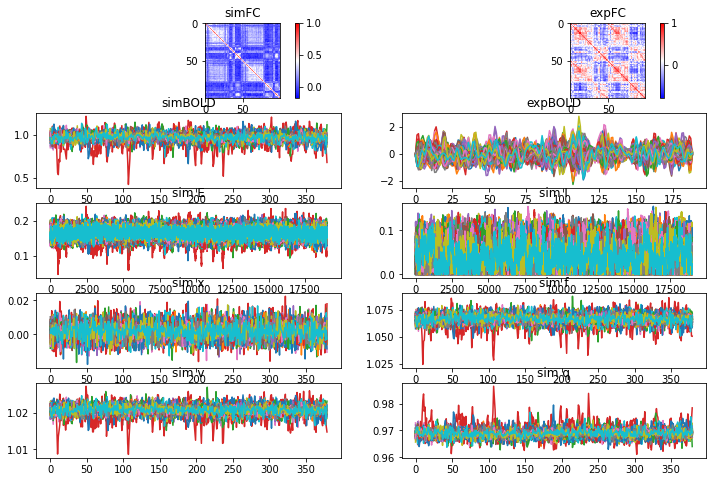

In [41]:
# Sub 1, Fit gains True, 80 epochs
sub = subs[1]
sc = dwiconn_dfs[sub].values.copy()
sc =0.5*(sc+sc.T)
sc = np.log1p(sc)/np.linalg.norm(np.log1p(sc))
ts = ptsrs_dfs[sub].values.copy()
fc_emp = np.corrcoef(ts.T)
model = RNNWWD(input_size=2, node_size=100, batch_size=19, step_size=0.05, tr=2.5, sc=sc, fit_gains=True,
               g_mean_ini=80, g_std_ini = .1, gEE_mean_ini=2.5, gEE_std_ini = .1)
F = Model_fitting(model, ts, num_epochs=40)
#### input optimal model parameters
g_optimal = par_opt[0]
g_EE_optimal = par_opt[1]
g_IE_optimal = par_opt[2]
g_EI_optimal = par_opt[3]
std_in_optimal = par_opt[4]
std_out_optimal = par_opt[5]
w_bb_optimal = gain_opt
F.model.g = Parameter(torch.tensor(g_optimal, dtype=torch.float32))
F.model.g_EE = Parameter(torch.tensor(g_EE_optimal, dtype=torch.float32))
F.model.g_EI = Parameter(torch.tensor(g_EI_optimal, dtype=torch.float32))
F.model.g_IE = Parameter(torch.tensor(g_IE_optimal, dtype=torch.float32))
F.model.w_bb = Parameter(torch.tensor(w_bb_optimal, dtype=torch.float32))
F.model.std_in = Parameter(torch.tensor(std_in_optimal, dtype=torch.float32))
F.model.std_out = Parameter(torch.tensor(std_out_optimal, dtype=torch.float32))

output_test = F.test(20)
plot_sim_states_outputs(ts, output_test)